In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

from datetime import datetime, timedelta
import time

import gc
import copy

import pyarrow.parquet as pq
import pyarrow as pa

 
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
random_seed=1234
pl.seed_everything(random_seed)



import torch
from torch import nn
import numpy as np


import torch
from torch.utils.data import (Dataset, DataLoader)


#basic libs

import pandas as pd
import numpy as np
import os
from pathlib import Path

from datetime import datetime, timedelta
import time
from dateutil.relativedelta import relativedelta

import gc
import copy

#additional data processing

import pyarrow.parquet as pq
import pyarrow as pa

from sklearn.preprocessing import StandardScaler, MinMaxScaler


#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#load images
import matplotlib.image as mpimg
import PIL
from PIL import Image




#settings
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

Image.MAX_IMAGE_PIXELS = None

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
random_seed=1234
pl.seed_everything(random_seed)

Global seed set to 1234
Global seed set to 1234


1234

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [3]:
folder = r"."
# folder = '/kaggle/input/mayo-clinic-strip-ai'
train_df = pd.read_csv(f'{folder}/train.csv')
other_df = pd.read_csv(f'{folder}//other.csv')

In [4]:
other_df['label'] = 'Other'

In [5]:
df = pd.concat([train_df[['image_id', 'patient_id', 'label']], 
                other_df[['image_id', 'patient_id', 'label']]], axis=0)
df.shape

(1150, 3)

In [6]:
label_dict ={'CE':0, 'LAA':1, 'Other':2}
df['target']=df['label'].map(label_dict)

In [7]:
img_folder = 'images'

In [8]:
import torch
from torch.utils.data import (Dataset, DataLoader)
  

class IMG_Data(Dataset):
    
    def __init__(self, root, data): 
        

        self.data = data
        self.root = root #image folder
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        image_id = self.data.iloc[idx]['image_id']
        img_path = f'{self.root}/{image_id}.png'
        y = self.data.iloc[idx]['target']
        if Path(img_path).exists():            

            img = Image.open(img_path)
            img, mask = self.mask_median(np.array(img))
            img = self.prune_image_rows_cols(img, mask)
            img = Image.fromarray(np.uint8(img))
            if (img.height> img.width):
                img = img.transpose(PIL.Image.ROTATE_90)
            ratio = img.height/img.width
            img = img.resize((512, int(512*ratio)), resample=Image.LANCZOS, reducing_gap=10)
            img = transforms.functional.center_crop(img, 512)
            img = transforms.functional.gaussian_blur(img, kernel_size=(5, 9), sigma=(0.1, 5))

            img = np.asarray(img)

            img = img.transpose((2,0,1))
            img = img/255
            img = transforms.functional.normalize(torch.FloatTensor(img), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            
            
        else:
            img = np.zeros((3, 512, 512), np.uint8)
            
        x = torch.FloatTensor(img)
        
        return x, y
    
    #https://www.kaggle.com/code/jirkaborovec/bloodclots-eda-load-wsi-prune-background?scriptVersionId=101797769
    @staticmethod
    def prune_image_rows_cols(im, mask, thr=0.990):
        # delete empty columns
        for l in reversed(range(im.shape[1])):
            if (np.sum(mask[:, l]) / float(mask.shape[0])) > thr:
                im = np.delete(im, l, 1)
        # delete empty rows
        for l in reversed(range(im.shape[0])):
            if (np.sum(mask[l, :]) / float(mask.shape[1])) > thr:
                im = np.delete(im, l, 0)
        return im

    @staticmethod
    def mask_median(im, val=255):
        masks = [None] * 3
        for c in range(3):
            masks[c] = im[..., c] >= np.median(im[:, :, c]) - 5
        mask = np.logical_and(*masks)
        im[mask, :] = val
        return im, mask
    

def load_data(df, batch_size, n_workers=0, shuffle=False):
    data = IMG_Data(img_folder, df)
    
    loader = DataLoader(data, batch_size=batch_size, num_workers=n_workers, shuffle=shuffle)
    
    return loader

In [9]:
######################################################################
# Training the model
# ------------------
#
# Now, let's write a general function to train a model. Here, we will
# illustrate:
#
# -  Scheduling the learning rate
# -  Saving the best model
#
# In the following, parameter ``scheduler`` is an LR scheduler object from
# ``torch.optim.lr_scheduler``.



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [10]:
train_loader = load_data(df.head(20), 4)

In [11]:
x, y = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


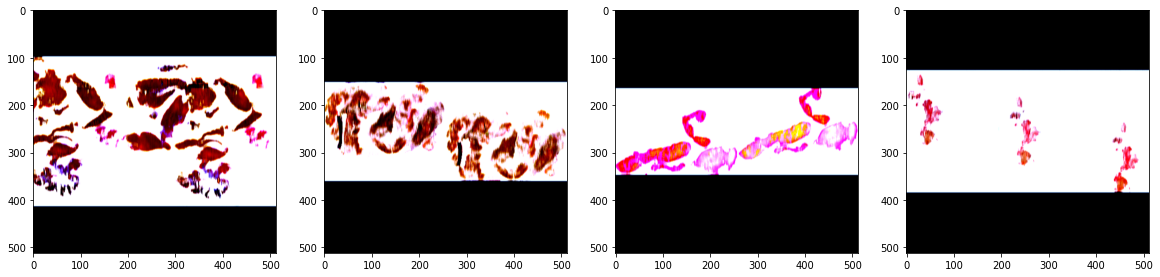

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=len(x), figsize=(20, 6))

for i in range(len(x)):
    x[i][x[i]<0] = 0
    axes[i].imshow(x[i].numpy().transpose((1,2,0)))

In [13]:
import pytorch_lightning as pl
random_seed=1234
pl.seed_everything(random_seed)

Global seed set to 1234


1234

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
#split data into train and eval sets
X_train, X_val, y_train, y_val = train_test_split(df[['image_id', 'label', 'target']], df['target'], test_size=0.25, random_state=1234)


In [16]:
#check the label distribution in train and val datasets
print('train data: ', len(X_train),  '-'*50)
display(X_train['label'].value_counts()/X_train.shape[0])
print('valuation data:', len(X_val), '-'*50)
display(X_val['label'].value_counts()/X_val.shape[0])

train data:  862 --------------------------------------------------


CE       0.476798
Other    0.345708
LAA      0.177494
Name: label, dtype: float64

valuation data: 288 --------------------------------------------------


CE       0.472222
Other    0.340278
LAA      0.187500
Name: label, dtype: float64

In [17]:
pl.seed_everything(random_seed)

Global seed set to 1234


1234

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
%%time
#load data to dataloaer
dataloaders = {'train': load_data(X_train, 4), 'val': load_data(X_val, 4)}
dataset_sizes = {'train': len(X_train), 'val':len(X_val)}

Wall time: 0 ns


In [23]:

######################################################################
# ConvNet as fixed feature extractor
# ----------------------------------
#
# Here, we need to freeze all the network except the final layer. We need
# to set ``requires_grad = False`` to freeze the parameters so that the
# gradients are not computed in ``backward()``.
#
# You can read more about this in the documentation
# `here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.
#

model_conv = torchvision.models.resnet18(pretrained=True, progress=False)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [24]:
######################################################################
# Train and evaluate
#
# On CPU this will take about half the time compared to previous scenario.
# This is expected as gradients don't need to be computed for most of the
# network. However, forward does need to be computed.
#

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

######################################################################


Epoch 0/49
----------
train Loss: 1.0982 Acc: 0.4060
val Loss: 1.0720 Acc: 0.4271

Epoch 1/49
----------
train Loss: 1.0640 Acc: 0.4466
val Loss: 1.0784 Acc: 0.4410

Epoch 2/49
----------
train Loss: 1.0414 Acc: 0.4640
val Loss: 1.0859 Acc: 0.4514

Epoch 3/49
----------
train Loss: 1.0232 Acc: 0.4756
val Loss: 1.0938 Acc: 0.4271

Epoch 4/49
----------
train Loss: 1.0079 Acc: 0.4791
val Loss: 1.1015 Acc: 0.4271

Epoch 5/49
----------
train Loss: 0.9945 Acc: 0.4942
val Loss: 1.1090 Acc: 0.4340

Epoch 6/49
----------
train Loss: 0.9826 Acc: 0.5023
val Loss: 1.1164 Acc: 0.4236

Epoch 7/49
----------
train Loss: 0.9032 Acc: 0.5905
val Loss: 1.0748 Acc: 0.4271

Epoch 8/49
----------
train Loss: 0.9026 Acc: 0.5916
val Loss: 1.0746 Acc: 0.4375

Epoch 9/49
----------
train Loss: 0.9015 Acc: 0.5928
val Loss: 1.0745 Acc: 0.4444

Epoch 10/49
----------
train Loss: 0.9005 Acc: 0.5916
val Loss: 1.0745 Acc: 0.4479

Epoch 11/49
----------
train Loss: 0.8995 Acc: 0.5916
val Loss: 1.0746 Acc: 0.4514

Ep